# MSc Health Data Science - Module 06 
## Inital processing of the lung X-ray images
#### >>lungs.ipynb

<br>

In [75]:
%matplotlib inline
# ^ this line makes plots appear in jupyter

import numpy as np                 # for working with arrays
import pandas as pd
import matplotlib.pyplot as plt    # for visualisation
import tensorflow as tf            # for neural networks
from PIL import Image

import os,os.path
import glob
import string
from sklearn.preprocessing import LabelEncoder

This is the slightly adopted version of the ```disp```function from  'msc_hds_m06_d05_e02.ipynb'

In [76]:


def disp(*imgs, pred_labels=None, true_labels=None, mode='squeeze'):
    """Accepts any number of images, and plots them in a row
    Uses grayscale colour mapping for single-channel images,
        and normal RGB for three-channel images.
    
    'mode' is an argument that controls default scaling
        of pixel values.
    If mode == 'clip', pixels below 0 are set to 0, 
        and pixels above 1 are set to 1.
    If mode == 'squeeze', the whole image is instead rescaled
        so that the min value is 0, and the max value is 1.
        
    Optionally accepts a a list, 'pred_labels', that indicates
      the true labels of the images plotted.
    If provided, will plot them on the graph as well.
    
    If you provide 'true_labels' as well, it will indicate
      where the predictions are wrong!"""
    
    scale_factor = 50
    
    # sanity check:
    if mode not in ['clip', 'squeeze']:
        raise Exception("'mode' arg must be either 'clip' or 'squeeze'")
                
    else:
        num_images = len(imgs)
        img_dims = imgs[0].shape
        # scale figure size with number of images:
        plt.rcParams['figure.figsize'] = [(img_dims[0]//scale_factor)*num_images, img_dims[1]//scale_factor]

        fig, axes = plt.subplots(1, num_images)
        
        
        for i, img in enumerate(imgs):           
            if mode == 'clip':
                # clip to interval [0,1]:
                output = img.clip(0,1)
                
            elif mode == 'squeeze':
                # rescale to interval [0,1]:
                output = (img - img.min()) / (img.max() - img.min())

            ax = axes[i] if num_images > 1 else axes
            ax.imshow(output, cmap='gray', vmin=0, vmax=1)
                        
            if (true_labels is not None) and (pred_labels is None):
                # just plot the true labels:
                pred_labels = true_labels
                true_labels = None
            
            if pred_labels is not None:
                if true_labels is not None:
                    correct = pred_labels[i] == true_labels[i]
                    title_colour = 'black' if correct else 'red'
                    title = pred_labels[i] if correct else f'{pred_labels[i]} ({true_labels[i]}!)'
                else:
                    title_colour='black'
                    title = pred_labels[i]
                ax.set_title(title, c=title_colour)
                
        plt.show()
        # return figure size to normal:
        plt.rcParams['figure.figsize'] = [8,4]


## Some othe helper functions

```create_df```  Creates a dataframe conating the images as numpy arrays - used internally

```read_image```  Reads in a single image file, converts it to greyscale and then into numpy

```read_images```  Reads in all image files in adirectory and returns a dataframe containing IDs, numpy array and class (named klass - not to confuse python as `class`is a reserved word



In [77]:
def create_df(data=None):
    return_df = pd.DataFrame(data,columns=['img_id','path','image_np','klass']).set_index('img_id')
    return return_df
    

def read_image(file_path):
    if os.path.exists(file_path):
        img = Image.open(file_path).convert('L')
        img_np = np.array(img.getchannel(0))
        
        return img_np

def read_images(base_image_path, klass='normal'):
    return_list = [] #create_empty_df()
    
    if os.path.exists(base_image_path):
        files      = glob.glob(f'{base_image_path}{os.path.sep}*.jpg')
        file_names = [(os.path.split(x)[-1]).split('.')[0] for x in files]
        for file_name in file_names:
            file_path = f'{base_image_path}{os.path.sep}{file_name}.jpg'
            file_id   = f'{klass}__{file_name.zfill(3)}'
            file_img  = read_image(file_path) 
            return_list.append((file_id,file_path,file_img,klass))
            
    return_df = create_df(return_list)
    return return_df
        

## Define basic information

In [78]:
data_dir = './lung'

sub_dirs = glob.glob(f'{data_dir}{os.path.sep}*')
klasses = [os.path.split(x)[-1] for x in  sub_dirs]
print(klasses)

['viral_pneumonia', 'lung_opacity', 'normal']


## Read in Dataset
Now read in the complete dataset. Please note that this can take a minute or two. You might want to save this dataframe either using ```to_csv``` or ```to_pickle``` (python compile format - very fast``` or similar.

In [93]:
dataset_df = create_df()
for klass in klasses:
    temp_df = read_images(f'{data_dir}{os.path.sep}{klass}',klass) 
    dataset_df = pd.concat([dataset_df, temp_df])
dataset_df

,path,image_np,klass
img_id,,,
viral_pneumonia__063,./lung/viral_pneumonia/63.jpg,"[[63, 64, 66, 69, 71, 74, 76, 77, 78, 79, 81, ...",viral_pneumonia
viral_pneumonia__823,./lung/viral_pneumonia/823.jpg,"[[155, 138, 123, 122, 128, 130, 127, 125, 123,...",viral_pneumonia
viral_pneumonia__189,./lung/viral_pneumonia/189.jpg,"[[64, 66, 69, 72, 74, 75, 75, 75, 77, 78, 84, ...",viral_pneumonia
viral_pneumonia__077,./lung/viral_pneumonia/77.jpg,"[[91, 105, 179, 168, 98, 87, 103, 123, 187, 12...",viral_pneumonia
viral_pneumonia__837,./lung/viral_pneumonia/837.jpg,"[[61, 65, 73, 78, 74, 80, 81, 170, 148, 101, 8...",viral_pneumonia
...,...,...,...
normal__052,./lung/normal/52.jpg,"[[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, ...",normal
normal__806,./lung/normal/806.jpg,"[[197, 184, 173, 171, 169, 162, 154, 149, 151,...",normal
normal__046,./lung/normal/46.jpg,"[[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, ...",normal


In [80]:
dataset_df['viral_pnuemonia']

(299, 299)

### Displaying individual images using the disp function

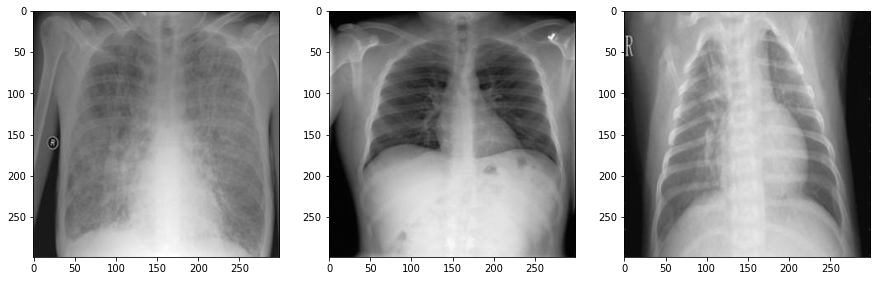

In [111]:
disp(dataset_df.loc['lung_opacity__457','image_np'],dataset_df.loc['normal__146','image_np'],dataset_df.loc['viral_pneumonia__063','image_np'])

### Displaying individual images using the disp function, now with labels 

Basically the same as in the exercises with the MNist fashion dataset. 

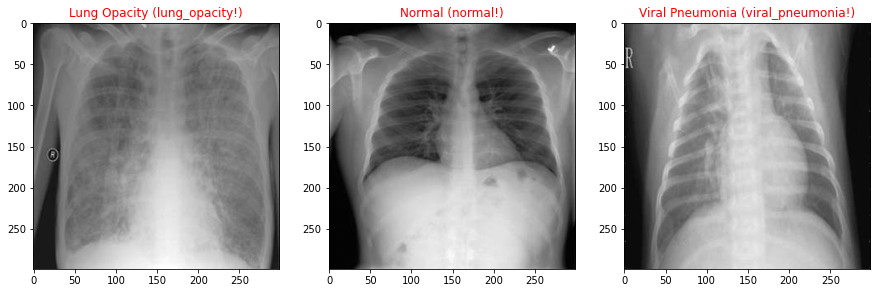

In [167]:
disp(dataset_df.loc['lung_opacity__457','image_np'],
     dataset_df.loc['normal__146','image_np'],
     dataset_df.loc['viral_pneumonia__063','image_np'],
     true_labels=[dataset_df.loc['lung_opacity__457','klass'],
                 dataset_df.loc['normal__146','klass'],
                 dataset_df.loc['viral_pneumonia__063','klass']],
     pred_labels=['Lung Opacity','Normal','Viral Pneumonia']
    )   
    

In [83]:
Z = dataset_df.reset_index()
X = Z['image_np'].tolist()
X = np.array(X)
y = Z['klass']
labels = LabelEncoder().fit_transform(y)
X.shape

(3475, 299, 299)

In [84]:
unique_values, counts = np.unique(labels, return_counts=True)

# Print the unique values and their counts
for value, count in zip(unique_values, counts):
    print(f"Value: {value}, Count: {count}")
    
## 0 -> Lung Opacity
## 1 -> Normal
## 2 -> Viral Pneumonia

Value: 0, Count: 1125
Value: 1, Count: 1250
Value: 2, Count: 1100


In [85]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split

# Load and preprocess the dataset
# Your code here

# Split the dataset into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_train, X_test, X_val = X_train/255., X_test/255., X_val/255.

[[0.38 0.35 0.31 ... 0.71 0.69 0.66]
 [0.25 0.23 0.2  ... 0.57 0.57 0.57]
 [0.15 0.14 0.13 ... 0.38 0.4  0.43]
 ...
 [0.12 0.11 0.13 ... 0.12 0.13 0.15]
 [0.13 0.13 0.15 ... 0.12 0.13 0.15]
 [0.13 0.14 0.17 ... 0.12 0.13 0.15]]


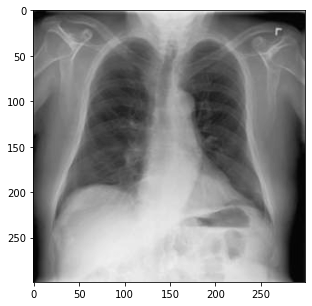

(299, 299)


In [86]:
first_image = X_train[0]
print(first_image.round(2))
disp(first_image)
print(X_train[0].shape)

In [113]:
# Not using 
y_train_onehot = tf.one_hot(y_train, depth=3)
y_test_onehot = tf.one_hot(y_test, depth=3)
y_val_onehot = tf.one_hot(y_val, depth=3)

# we can see that this new array is as long as the original list of integers, but has 10 times as many elements:
print(y_train_onehot.shape)
print(y_test_onehot.shape)
print(y_val_onehot.shape)
# this is because each label is now a row of 10 binary values:
print(y_train_onehot[:5])

(2224, 3)
(695, 3)
(556, 3)
tf.Tensor(
[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]], shape=(5, 3), dtype=float32)


In [126]:
print(type(X_train))
print(type(X_test))
print(type(X_val))

print(type(y_train))
print(type(y_test))
print(type(y_val))

print(type(y_train_onehot))
print(type(y_test_onehot))
print(type(y_val_onehot))

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

print(y_train_onehot.shape)
print(y_test_onehot.shape)
print(y_val_onehot.shape)

print(X_train[0].shape)
print(X_test[0].shape)
print(X_val[0].shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
(2224, 299, 299, 1)
(695, 299, 299, 1)
(556, 299, 299, 1)
(2224,)
(695,)
(556,)
(2224, 3)
(695, 3)
(556, 3)
(299, 299, 1)
(299, 299, 1)
(299, 299, 1)


In [161]:
X_train = X_train.reshape(-1, 299, 299, 1)
X_val = X_val.reshape(-1, 299, 299, 1)
X_test = X_test.reshape(-1, 299, 299, 1)

In [177]:
#CNN
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, optimizers, losses
from tensorflow.keras import layers, regularizers

X_train = X_train.reshape(-1, 299, 299, 1)
X_val = X_val.reshape(-1, 299, 299, 1)
X_test = X_test.reshape(-1, 299, 299, 1)

# Define the CNN model architecture
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(299,299, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# If you're using sparse_categorical_crossentropy loss during training, you should use integer labels (y_test) during evaluation.
# If you're using categorical_crossentropy loss during training, you should use one-hot encoded labels (y_test_onehot) during evaluation.

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))



Epoch 1/10
70/70 [==============================] - 313s 4s/step - loss: 0.7735 - accuracy: 0.6623 - val_loss: 0.5055 - val_accuracy: 0.8147
Epoch 2/10
70/70 [==============================] - 229s 3s/step - loss: 0.4629 - accuracy: 0.8107 - val_loss: 0.4544 - val_accuracy: 0.8219
Epoch 3/10
70/70 [==============================] - 224s 3s/step - loss: 0.3708 - accuracy: 0.8503 - val_loss: 0.3938 - val_accuracy: 0.8561
Epoch 4/10
70/70 [==============================] - 230s 3s/step - loss: 0.3332 - accuracy: 0.8620 - val_loss: 0.4369 - val_accuracy: 0.8147
Epoch 5/10
70/70 [==============================] - 225s 3s/step - loss: 0.2756 - accuracy: 0.8903 - val_loss: 0.4150 - val_accuracy: 0.8435
Epoch 6/10
70/70 [==============================] - 224s 3s/step - loss: 0.2211 - accuracy: 0.9168 - val_loss: 0.4379 - val_accuracy: 0.8345
Epoch 7/10
70/70 [==============================] - 222s 3s/step - loss: 0.1924 - accuracy: 0.9272 - val_loss: 0.4449 - val_accuracy: 0.8453
Epoch 8/10
70

22/22 [==============================] - 21s 877ms/step - loss: 0.5053 - accuracy: 0.8504
Test Loss: 0.505253791809082, Test Accuracy: 0.8503597378730774


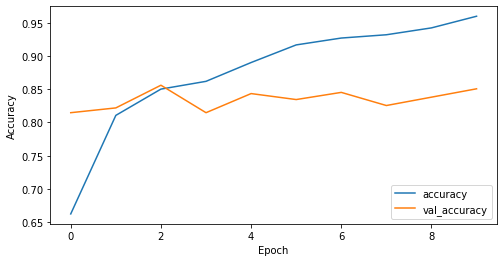

22/22 [==============================] - 21s 962ms/step


In [178]:
# without L2 regularization 
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Make predictions on new data
predictions = model.predict(X_test)


In [72]:
predictions.round(2).shape

(695, 3)

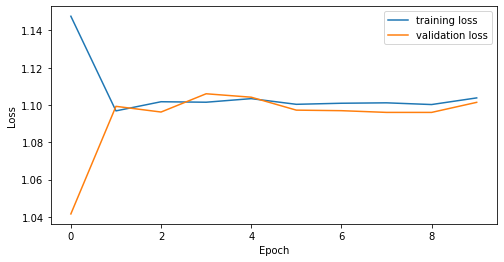

In [179]:
# without L2 regularization 
# you could look at the 'history' that we were given when the model finished training,
# and see if this is helpful to you:

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['training loss', 'validation loss'])
plt.show()

22/22 [==============================] - 23s 995ms/step - loss: 0.5315 - accuracy: 0.8245
Test Loss: 0.5315489768981934, Test Accuracy: 0.8244604468345642


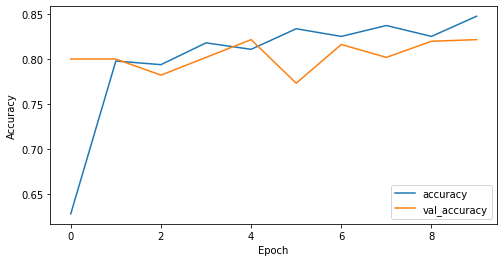

22/22 [==============================] - 22s 974ms/step


In [173]:
# with L2 regularization 
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Make predictions on new data
predictions = model.predict(X_test)

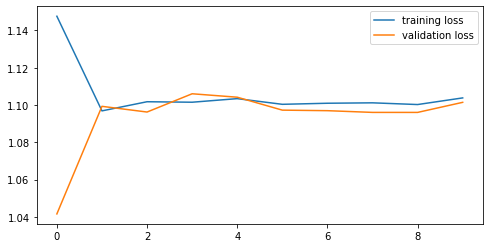

In [174]:
# with L2 regularization 
# you could look at the 'history' that we were given when the model finished training,
# and see if this is helpful to you:

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['training loss', 'validation loss'])
plt.show()

In [131]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


70/70 [==============================] - 3s 45ms/step - loss: 1.1062


TypeError: cannot unpack non-iterable float object

In [125]:
X_test.shape


(695, 299, 299, 1)

In [143]:
from sklearn.metrics import classification_report


# Convert one-hot encoded predictions back to integer labels
predicted_labels = np.argmax(predictions, axis=1)

# Print classification report for test set
print("Test Set Performance:")
print(classification_report(y_test, predicted_labels))



              precision    recall  f1-score   support

           0       0.90      0.64      0.75       225
           1       0.73      0.91      0.81       250
           2       0.95      0.95      0.95       220

    accuracy                           0.84       695
   macro avg       0.86      0.83      0.84       695
weighted avg       0.85      0.84      0.83       695



In [168]:
#SVM
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def extract_hog_features(images):
    hog_features = []
    for image in images:
        #Histogram of Oriented Gradients, also known as HOG, is a feature descriptor used in computer vision
        #and image processing for the purpose of object detection1. 
        #The technique counts occurrences of gradient orientation in the localized portion of an image1. 
        #Here are the steps to calculate HOG features1:
        # Calculate HOG features for each image
        features = hog(image, orientations=9, pixels_per_cell=(16, 16),
                       cells_per_block=(2, 2), transform_sqrt=True, block_norm='L2-Hys')
        hog_features.append(features)
    return np.array(hog_features)

# Extract HOG features from training, validation, and test images
X_train_hog = extract_hog_features(X_train)
X_val_hog = extract_hog_features(X_val)
X_test_hog = extract_hog_features(X_test)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_hog)
X_val_scaled = scaler.transform(X_val_hog)
X_test_scaled = scaler.transform(X_test_hog)

# Train SVM classifier on the training set
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale')  # You can adjust hyperparameters as needed
svm_model.fit(X_train_scaled, y_train)

# Make predictions on the validation set
y_val_pred = svm_model.predict(X_val_scaled)

# Print classification report for validation set
print("Validation Set Performance:")
print(classification_report(y_val, y_val_pred))

# Make predictions on the test set
y_test_pred_svm = svm_model.predict(X_test_scaled)

# Print classification report for test set
print("Test Set Performance:")
print(classification_report(y_test, y_test_pred_svm))



Validation Set Performance:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83       190
           1       0.83      0.83      0.83       201
           2       0.96      0.98      0.97       165

    accuracy                           0.87       556
   macro avg       0.87      0.88      0.88       556
weighted avg       0.87      0.87      0.87       556

Test Set Performance:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       225
           1       0.83      0.86      0.85       250
           2       0.98      0.98      0.98       220

    accuracy                           0.89       695
   macro avg       0.89      0.89      0.89       695
weighted avg       0.89      0.89      0.89       695



NameError: name 'confusion_matrix' is not defined

In [169]:
from sklearn.metrics import classification_report, confusion_matrix
# Generate confusion matrix
conf_matrix_svm = confusion_matrix(y_test, y_test_pred_svm)
print("Confusion Matrix:")
print(conf_matrix_svm)

Confusion Matrix:
[[186  39   0]
 [ 31 215   4]
 [  1   4 215]]


In [170]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)


# Train Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust hyperparameters as needed
rf_model.fit(X_train_flat, y_train)

# Make predictions on the validation set
y_val_pred_rf = rf_model.predict(X_val_flat)

# Print classification report for validation set
print("Validation Set Performance:")
print(classification_report(y_val, y_val_pred_rf))

# Make predictions on the test set
y_test_pred_rf = rf_model.predict(X_test_flat)

# Print classification report for test set
print("Test Set Performance:")
print(classification_report(y_test, y_test_pred_rf))

# Generate confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_test_pred_rf)
print("Confusion Matrix:")
print(conf_matrix_rf)

Validation Set Performance:
              precision    recall  f1-score   support

           0       0.82      0.77      0.79       190
           1       0.81      0.81      0.81       201
           2       0.90      0.96      0.93       165

    accuracy                           0.84       556
   macro avg       0.84      0.84      0.84       556
weighted avg       0.84      0.84      0.84       556

Test Set Performance:
              precision    recall  f1-score   support

           0       0.82      0.76      0.79       225
           1       0.79      0.81      0.80       250
           2       0.92      0.95      0.94       220

    accuracy                           0.84       695
   macro avg       0.84      0.84      0.84       695
weighted avg       0.84      0.84      0.84       695

Confusion Matrix:
[[171  47   7]
 [ 35 203  12]
 [  3   7 210]]


In [172]:
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split



# Define XGBoost classifier
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',  # Multiclass classification
    num_class=3,      # Number of classes
    n_estimators=100,           # Number of trees (boosting rounds)
    random_state=42             # Random state for reproducibility
)

# Train XGBoost classifier on the training set
xgb_model.fit(X_train_flat, y_train, eval_set=[(X_val_flat, y_val)], early_stopping_rounds=10, verbose=False)

# Make predictions on the validation set
y_val_pred = xgb_model.predict(X_val_flat)

# Print classification report for validation set
print("Validation Set Performance:")
print(classification_report(y_val, y_val_pred))

# Make predictions on the test set
y_test_pred_xg = xgb_model.predict(X_test_flat)

# Print classification report for test set
print("Test Set Performance:")
print(classification_report(y_test, y_test_pred_xg))

# Generate confusion matrix
conf_matrix_xg = confusion_matrix(y_test, y_test_pred_xg)
print("Confusion Matrix:")
print(conf_matrix_xg)

# Generate confusion matrix
conf_matrix_xg = confusion_matrix(y_test, y_test_pred_xg)
print("Confusion Matrix:")
print(conf_matrix_xg)



/Users/Prince/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


Validation Set Performance:
              precision    recall  f1-score   support

           0       0.82      0.79      0.81       190
           1       0.82      0.82      0.82       201
           2       0.90      0.95      0.92       165

    accuracy                           0.85       556
   macro avg       0.85      0.85      0.85       556
weighted avg       0.85      0.85      0.85       556

Test Set Performance:
              precision    recall  f1-score   support

           0       0.85      0.78      0.81       225
           1       0.80      0.84      0.82       250
           2       0.93      0.95      0.94       220

    accuracy                           0.86       695
   macro avg       0.86      0.86      0.86       695
weighted avg       0.86      0.86      0.86       695

Confusion Matrix:
[[175  45   5]
 [ 29 211  10]
 [  3   7 210]]
Confusion Matrix:
[[175  45   5]
 [ 29 211  10]
 [  3   7 210]]
